In [1]:
"""Train a hyperbolic embedding model for hierarchical clustering."""

import argparse
import json
import logging
import os

import numpy as np
import torch
import torch.utils.data as data
import tqdm
import matplotlib.pyplot as plt

import optim
from config import config_args
from datasets.hc_dataset import HCDataset
from datasets.loading import load_data
from utils.poincare import project
from utils.metrics import dasgupta_cost
from utils.training import add_flags_from_config, get_savedir

from model.hyphc import HypHC
from model.linear import HypHCLinear

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import scipy
import msprime 

seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float64)

ts = msprime.sim_ancestry(
    samples=10,
    population_size=10000,
    ploidy=1,
    recombination_rate=1E-8,
    sequence_length=100,
    random_seed=seed,
    model=msprime.StandardCoalescent(duration=1E5)
)

ts = msprime.sim_mutations(
    ts, rate=1e-5, random_seed=seed, model="binary",
)

In [39]:
# sample distance matrix (n_samples, n_samples)
similarities = 1 - scipy.spatial.distance.pdist(h, 'cosine')
similarities = scipy.spatial.distance.squareform(similarities)

ts_data = {"genotypes": ts.genotype_matrix().T, "samples": ts.samples(), "sites": [s.position for s in ts.sites()]}

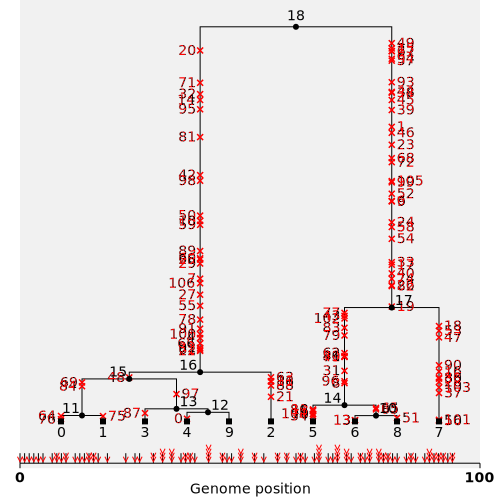

In [3]:
ts.draw_svg(size=(500, 500))

In [59]:
from utils.visualization import vis_embeddings

Generating all pairs subset


100%|██████████| 50/50 [00:01<00:00, 40.97it/s]

Initial loss: 1.2404171347553228
Epoch: 50, Average Loss: 0.9632535602399839, Scale: 0.5669934928952413, lr: 0.025, temperature: 0.025
lr: 0.1, loss: 0.9632535602399839


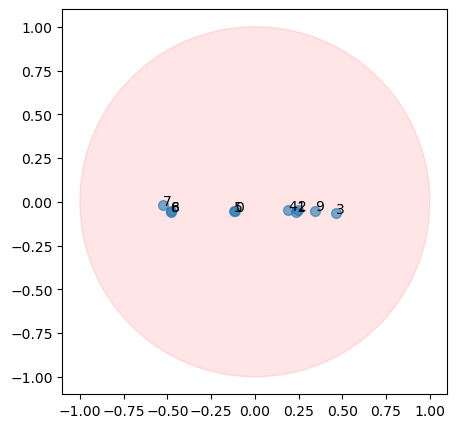

In [40]:
from itertools import product

batch_size = 10
epochs = 50
temperature = 5e-2
eval_every = 1
patience = 40
anneal_every = 25
anneal_factor = 0.5
init_size = .15
rank=4
max_scale = 1
len_sequences = h.shape[1]

dataset = HCDataset(ts_data["genotypes"], ts_data["samples"], similarities, num_samples=len(ts_data["samples"]))
dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=False, persistent_workers=True)

best_model = None
best_loss = np.inf

for learning_rate, temperature in product([1e-1], [1e-1]):

    # create model
    #model = HypHC(dataset.n_nodes, rank, temperature, init_size, max_scale)
    model = HypHCLinear(n_nodes=dataset.n_nodes, rank=rank, temperature=temperature, 
                        init_size=init_size, max_scale=max_scale, alphabet_size=1,
                        sequence_length=len_sequences)

    # create optimizer
    optimizer = optim.RAdam(model.parameters(), learning_rate)

    # train model
    counter = 0
    #print("Start training")
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        total_loss = 0.0

        for step, (triple_ids, triple_similarities) in enumerate(dataloader):

            loss = model.loss(triple_ids, triple_similarities)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss

        total_loss = total_loss.item() / (step + 1.0)

        # print initial loss:
        if epoch == 0:
            print(f"Initial loss: {total_loss}")

        if model.scale.data[0] < model.init_size:
            model.scale.data[0] = model.init_size

        # anneal temperature
        if (epoch + 1) % anneal_every == 0:
            model.anneal_temperature(anneal_factor)
            #print("Annealing temperature to: {}".format(model.temperature))
            for param_group in optimizer.param_groups:
                param_group['lr'] *= anneal_factor
                lr = param_group['lr']
            #print("Annealing learning rate to: {}".format(lr))

    if best_loss > total_loss:
        best_loss = total_loss
        best_model = model
    print(f"Epoch: {epoch+1}, Average Loss: {total_loss}, Scale: {model.scale.data[0]}, lr: {lr}, temperature: {model.temperature}")


    # evaluation
    model.eval()

    print(f"lr: {learning_rate}, loss: {total_loss}")

vis_embeddings(best_model, ts.samples())

In [60]:
import tskit

from utils.linkage import build_ts_from_embeddings
        
leaves_embeddings = best_model.normalize_embeddings(best_model.embeddings.weight.data)
#leaves_embeddings = best_model.embeddings.weight.data
leaves_embeddings = project(leaves_embeddings).detach().cpu()

infered_ts = build_ts_from_embeddings(leaves_embeddings, ts.samples(), ts.sequence_length)
infered_ts.draw_svg(size=(500,500))

TypeError: build_ts_from_embeddings() takes 2 positional arguments but 3 were given

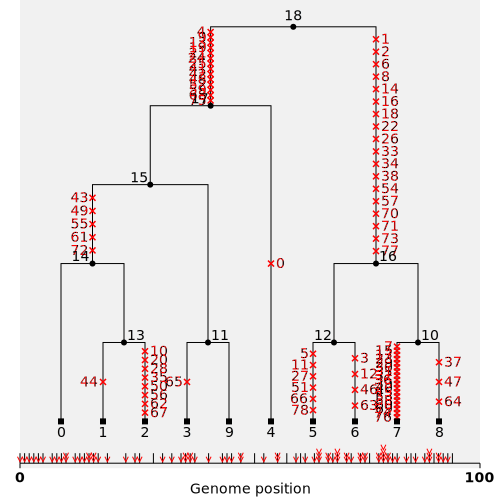

In [58]:
from utils.tree import map_mutations

mapped_inferred_ts = map_mutations(infered_ts, ts_data)
mapped_inferred_ts.draw_svg(size=(500,500))

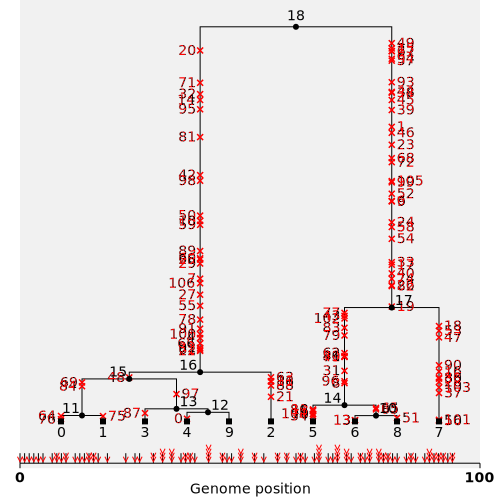

In [54]:
ts.draw_svg(size=(500,500))